# Necessary modules

In [1]:
!pip install uproot vector

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 365.0/365.0 kB 13.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 177.8/177.8 kB 10.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 879.3/879.3 kB 23.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 638.7/638.7 kB 9.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.8/194.8 kB 6.9 MB/s eta 0:00:00


In [2]:
import uproot
import gdown
import os
import requests
from tqdm import tqdm
import pandas as pd
import numpy as np
import awkward as ak
import vector
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches

# JetClass

In [3]:
# Download JetClass dataset file
def _download(url, fname, chunk_size=1024):
    '''https://gist.github.com/yanqd0/c13ed29e29432e3cf3e7c38467f42f51'''
    resp = requests.get(url, stream=True)
    total = int(resp.headers.get('content-length', 0))
    with open(fname, 'wb') as file, tqdm(
        desc=fname,
        total=total,
        unit='iB',
        unit_scale=True,
        unit_divisor=1024,
    ) as bar:
        for data in resp.iter_content(chunk_size=chunk_size):
            size = file.write(data)
            bar.update(size)

# Download the example file
example_file = 'JetClass_example_100k.root'
if not os.path.exists(example_file):
    _download('https://hqu.web.cern.ch/datasets/JetClass/example/JetClass_example_100k.root', example_file)

JetClass_example_100k.root: 100%|██████████| 130M/130M [00:07<00:00, 17.8MiB/s]


In [4]:
tree = uproot.open(example_file)['tree']
table = tree.arrays()

In [5]:
# Get list with indices for which label_QCD = 1
QCD_indices = np.where(table['label_QCD'] == 1)[0]
QCD_jet = table[QCD_indices[0]]

# Get list with indices for wich label_Hbb = True
Hbb_indices = np.where(table['label_Hbb'] == True)[0]
Hbb_jet = table[Hbb_indices[0]]

# Get list with indices for which label_Hcc = True
Hcc_indices = np.where(table['label_Hcc'] == True)[0]
Hcc_jet = table[Hcc_indices[0]]

# Get list with indices for which label_Hgg = True
Hgg_indices = np.where(table['label_Hgg'] == True)[0]
Hgg_jet = table[Hgg_indices[0]]

# Get list with indices for which label_H4q = True
H4q_indices = np.where(table['label_H4q'] == True)[0]
H4q_jet = table[H4q_indices[0]]

# Get list with indices for which label_Hqql = True
Hqql_indices = np.where(table['label_Hqql'] == True)[0]
Hqql_jet = table[Hqql_indices[0]]

# Get list with indices for which label_Zqq = 1
Zqq_indices = np.where(table['label_Zqq'] == 1)[0]
Zqq_jet = table[Zqq_indices[0]]

# Get list with indices for which label_Wqq = 1
Wqq_indices = np.where(table['label_Wqq'] == 1)[0]
Wqq_jet = table[Wqq_indices[0]]

# Get list with indices for which label_Tbqq = 1
Tbqq_indices = np.where(table['label_Tbqq'] == 1)[0]
Tbqq_jet = table[Tbqq_indices[0]]

# Get list with indices for which label_Tbl =1
Tbl_indices = np.where(table['label_Tbl'] == 1)[0]
Tbl_jet = table[Tbl_indices[0]]

In [19]:
# Function to only get the necessary features for the plot
def convert_awkward_to_plot_format(awk_array):
    # Extract features from Awkward Array
    deta = ak.to_numpy(awk_array["part_deta"])
    dphi = ak.to_numpy(awk_array["part_dphi"])
    energy = ak.to_numpy(awk_array["part_energy"])

    # Particle Type Indicators
    is_charged_hadron = ak.to_numpy(awk_array["part_isChargedHadron"])
    is_neutral_hadron = ak.to_numpy(awk_array["part_isNeutralHadron"])
    is_photon = ak.to_numpy(awk_array["part_isPhoton"])
    is_electron = ak.to_numpy(awk_array["part_isElectron"])
    is_muon = ak.to_numpy(awk_array["part_isMuon"])

    # Charge determination:
    # - Charged hadrons, electrons, and muons → charge = 1
    # - Neutral hadrons & photons → charge = 0
    charge = np.where((is_charged_hadron == 1) | (is_electron == 1) | (is_muon == 1), 1, 0)

    # Assign particle IDs based on given conditions
    particle_id = np.zeros_like(is_charged_hadron)  # Default: 0 (hadrons)
    particle_id[is_electron == 1] = 1  # Electron
    particle_id[is_muon == 1] = 2      # Muon
    particle_id[is_photon == 1] = 3    # Photon

    # Stack all features into a single numpy array
    jet_data = np.column_stack((deta, dphi, energy, charge, particle_id))

    return jet_data

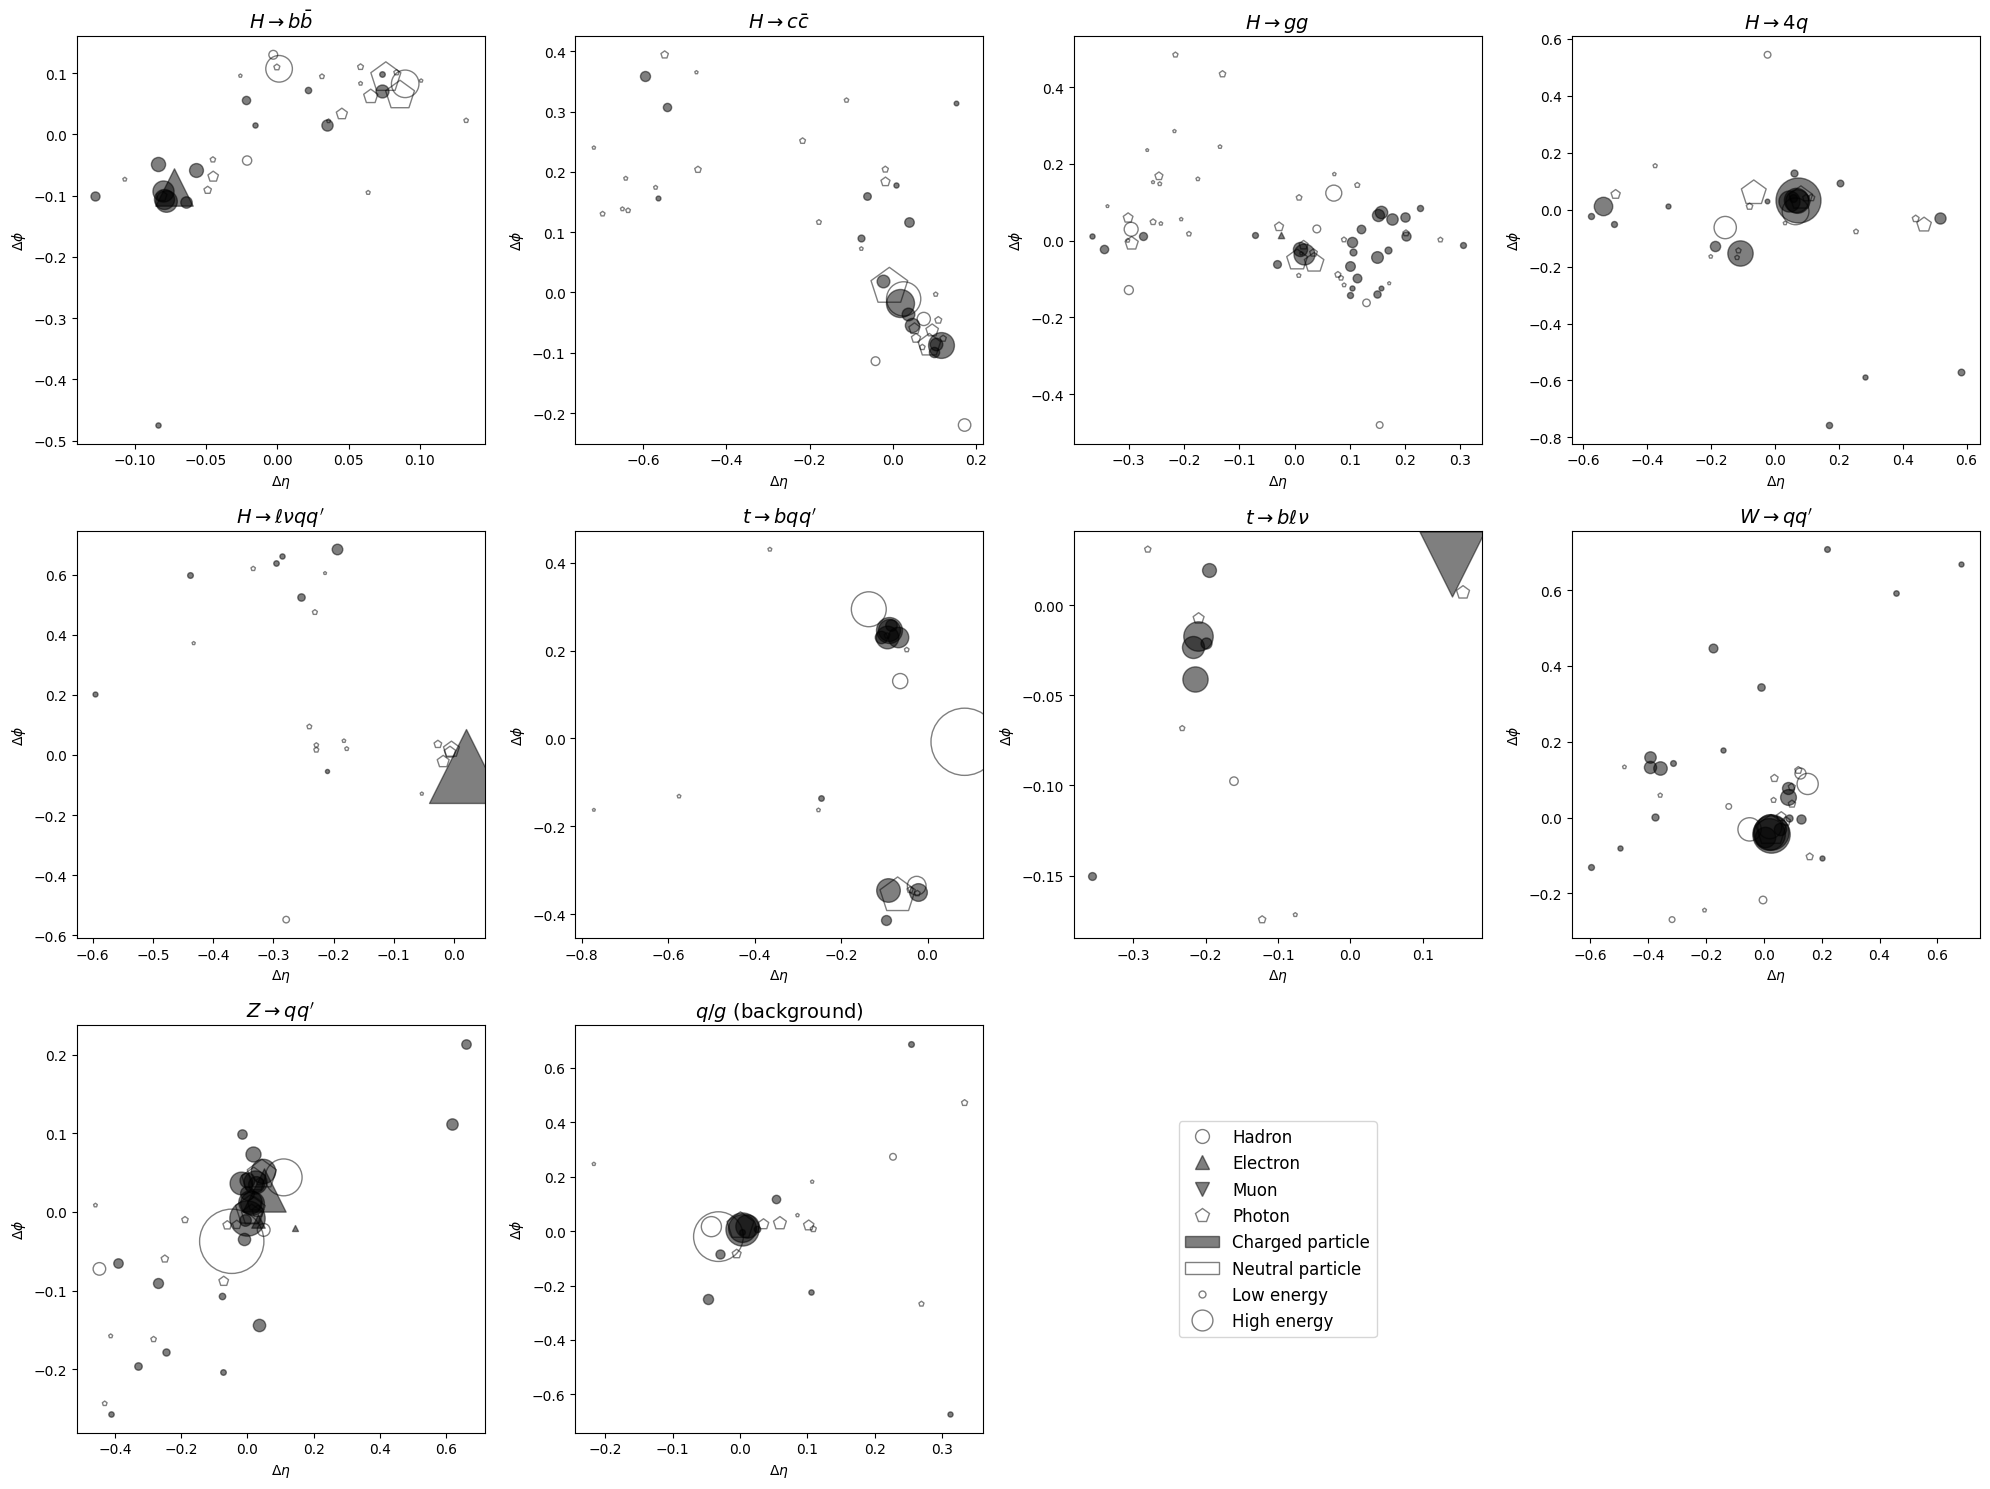

In [7]:
# Putting all jet types in a dictionary
jets_data = {
    r"$H \to b\bar{b}$": convert_awkward_to_plot_format(Hbb_jet),
    r"$H \to c\bar{c}$": convert_awkward_to_plot_format(Hcc_jet),
    r"$H \to gg$": convert_awkward_to_plot_format(Hgg_jet),
    r"$H \to 4q$": convert_awkward_to_plot_format(H4q_jet),
    r"$H \to \ell\nu qq'$": convert_awkward_to_plot_format(Hqql_jet),
    r"$t \to bqq'$": convert_awkward_to_plot_format(Tbqq_jet),
    r"$t \to b\ell\nu$": convert_awkward_to_plot_format(Tbl_jet),
    r"$W \to qq'$": convert_awkward_to_plot_format(Wqq_jet),
    r"$Z \to qq'$": convert_awkward_to_plot_format(Zqq_jet),
    r"$q/g$ (background)": convert_awkward_to_plot_format(QCD_jet),
}

# Particle type to marker mapping
particle_shapes = {
    0: "o",   # Hadron (charged or neutral)
    1: "^",   # Electron
    2: "v",   # Muon
    3: "p"    # Photon
}

def plot_jets(jets_data, filename):
    n = len(jets_data)
    rows, cols = 3, [4, 4, 2]

    fig, axes = plt.subplots(rows, max(cols), figsize=(20, 15))
    axes = axes.flatten()

    # Specify colors used
    colour = "black"
    alpha = 0.5

    # Plot each jet
    for ax, (jet_name, data) in zip(axes[:n], jets_data.items()):
        for row in data:
            deta, dphi, energy, charge, particle_id = row
            marker = particle_shapes[int(particle_id)]
            facecolor = colour if charge == 1 else "none"
            size = energy * 5

            ax.scatter(deta, dphi, s=size, marker=marker, facecolor=facecolor, edgecolor=colour, alpha=alpha)

        ax.set_title(jet_name, fontsize=14)
        ax.set_xlabel(r"$\Delta \eta$")
        ax.set_ylabel(r"$\Delta \phi$")
        ax.grid(False)

    # Create legend
    legend_index = len(axes) - 2
    legend_ax = axes[legend_index]
    legend_ax.axis("off")


    # Remove extra empty subplots in last row (if jets < 10)
    for i in range(n, len(axes)):
        if i != legend_index:
            fig.delaxes(axes[i])

    legend_patches = []

    # Create legend for different particle types
    for particle_id, marker in particle_shapes.items():
        label = {0: "Hadron", 1: "Electron", 2: "Muon", 3: "Photon"}[particle_id]
        markerfacecolor = colour if particle_id in [1, 2] else "none"
        legend_patches.append(plt.Line2D([0], [0], marker=marker, markerfacecolor=markerfacecolor, markeredgecolor=colour, alpha=alpha, linestyle='None',
                                         markersize=10, label=label))

    # Create legend for charge
    legend_patches.append(mpatches.Patch(facecolor=colour, edgecolor=colour, alpha=alpha, label="Charged particle"))
    legend_patches.append(mpatches.Patch(facecolor="none", edgecolor=colour, alpha=alpha, label="Neutral particle"))

    # Create legend for energy scaling
    legend_patches.append(plt.Line2D([0], [0], marker="o", markerfacecolor="none", markeredgecolor=colour, alpha=alpha, linestyle='None',
                                     markersize=5, label="Low energy"))
    legend_patches.append(plt.Line2D([0], [0], marker="o", markerfacecolor="none", markeredgecolor=colour, alpha=alpha, linestyle='None',
                                     markersize=15, label="High energy"))

    legend_ax.legend(handles=legend_patches, loc='center', fontsize=12, title=None)

    plt.tight_layout()
    plt.savefig(filename)
    plt.show()

# Plot jets
plot_jets(jets_data, 'JetClassVis.pdf')

# TopLandscape

In [8]:
# Download TopLandscape dataset file from drive

# Training data - https://drive.google.com/file/d/1-CLSkZV-rFvmh1drhyyjTi98h8NhHr8F/view?usp=sharing
file_id = '1-CLSkZV-rFvmh1drhyyjTi98h8NhHr8F'
gdown.download(f'https://drive.google.com/uc?id={file_id}', quiet=False)

Downloading...
From: https://drive.google.com/uc?id=1-CLSkZV-rFvmh1drhyyjTi98h8NhHr8F
To: /content/TopLandscape_train_12k.csv
100%|██████████| 53.8M/53.8M [00:01<00:00, 32.8MB/s]


'TopLandscape_train_12k.csv'

In [9]:
# Get data to variable
data_train = pd.read_csv("/content/TopLandscape_train_12k.csv")

In [10]:
# Transform to obtain necessary features for plot
def _p4_from_pxpypze(px, py, pz, energy):
    import vector
    vector.register_awkward()
    return vector.zip({'px': px, 'py': py, 'pz': pz, 'energy': energy})

def _transform(dataframe, start=0, stop=-1):

    df = dataframe.iloc[start:stop]

    def _col_list(prefix, max_particles=200):
        return ['%s_%d' % (prefix, i) for i in range(max_particles)]

    _px = df[_col_list('PX')].values
    _py = df[_col_list('PY')].values
    _pz = df[_col_list('PZ')].values
    _e = df[_col_list('E')].values

    mask = _e > 0
    n_particles = np.sum(mask, axis=1)

    px = ak.unflatten(_px[mask], n_particles)
    py = ak.unflatten(_py[mask], n_particles)
    pz = ak.unflatten(_pz[mask], n_particles)
    energy = ak.unflatten(_e[mask], n_particles)

    p4 = _p4_from_pxpypze(px, py, pz, energy)

    jet_p4 = ak.sum(p4, axis=1)

    # outputs
    v = {}
    v['label'] = df['is_signal_new'].values

    v['jet_pt'] = jet_p4.pt
    v['jet_eta'] = jet_p4.eta
    v['jet_phi'] = jet_p4.phi
    v['jet_energy'] = jet_p4.energy
    v['jet_mass'] = jet_p4.mass
    v['jet_nparticles'] = n_particles

    v['part_px'] = px
    v['part_py'] = py
    v['part_pz'] = pz
    v['part_energy'] = energy

    _jet_etasign = ak.to_numpy(np.sign(v['jet_eta']))
    _jet_etasign[_jet_etasign == 0] = 1
    v['part_deta'] = (p4.eta - v['jet_eta']) * _jet_etasign
    v['part_dphi'] = p4.deltaphi(jet_p4)

    return v

In [15]:
# Transform the imported data to obtain all the necessary features
transformed_data = _transform(data_train)
transformed_data = ak.Array(transformed_data)

In [16]:
# Get list for which label = 1
Top_TP_indices = np.where(transformed_data['label'] == 1)[0]
Top_TP_jet = transformed_data[Top_TP_indices[0]]

# Get list for which label = 0
QCD_TP_indices = np.where(transformed_data['label'] == 0)[0]
QCD_TP_jet = transformed_data[QCD_TP_indices[0]]

In [17]:
# Function to only get the necessary features for the plot
def convert_awkward_to_plot_format_TL(awk_array):
    deta = ak.to_numpy(awk_array["part_deta"])
    dphi = ak.to_numpy(awk_array["part_dphi"])
    energy = ak.to_numpy(awk_array["part_energy"])

    # Stack all features into a single numpy array
    jet_data = np.column_stack((deta, dphi, energy))

    return jet_data

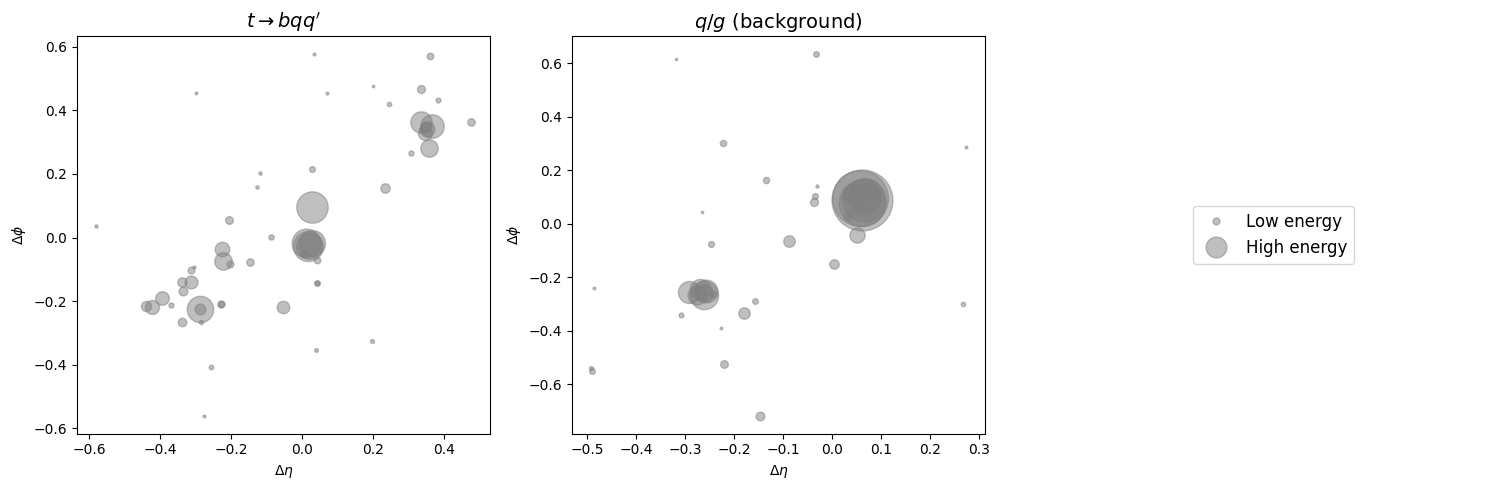

In [20]:
# Jet types in a dictionary
jets_data_TL = {
    r"$t \to bqq'$": convert_awkward_to_plot_format_TL(Top_TP_jet),
    r"$q/g$ (background)": convert_awkward_to_plot_format_TL(QCD_TP_jet)
}

def plot_jets_TL(jets_data, filename):
    n = len(jets_data)
    rows, cols = 1, [3]

    fig, axes = plt.subplots(rows, max(cols), figsize=(15, 5))
    axes = axes.flatten()

    # Specify colors used
    colour = "grey"
    alpha = 0.5

    # Plot each jet
    for ax, (jet_name, data) in zip(axes[:n], jets_data.items()):
        for row in data:
            deta, dphi, energy = row
            size = energy * 5

            ax.scatter(deta, dphi, s=size, marker="o", facecolor=colour, edgecolor=colour, alpha=alpha)

        ax.set_title(jet_name, fontsize=14)
        ax.set_xlabel(r"$\Delta \eta$")
        ax.set_ylabel(r"$\Delta \phi$")
        ax.grid(False)

    # Remove extra empty subplots in last row
    for i in range(n, len(axes) - 1):
        fig.delaxes(axes[i])

    # Create legend in the last available slot
    legend_ax = axes[-1]
    legend_ax.axis("off")

    legend_patches = []

    # Create legend for energy scaling
    legend_patches.append(plt.Line2D([0], [0], marker="o", markerfacecolor=colour, markeredgecolor=colour, alpha=alpha, linestyle='None',
                                     markersize=5, label="Low energy"))
    legend_patches.append(plt.Line2D([0], [0], marker="o", markerfacecolor=colour, markeredgecolor=colour, alpha=alpha, linestyle='None',
                                     markersize=15, label="High energy"))

    legend_ax.legend(handles=legend_patches, loc='center', fontsize=12, title=None)

    plt.tight_layout()
    plt.savefig(filename)
    plt.show()

# Plot jets
plot_jets_TL(jets_data_TL, "TopLandscapeVis.pdf")